# **Game Play Time Series Forecasting - Kaggle**
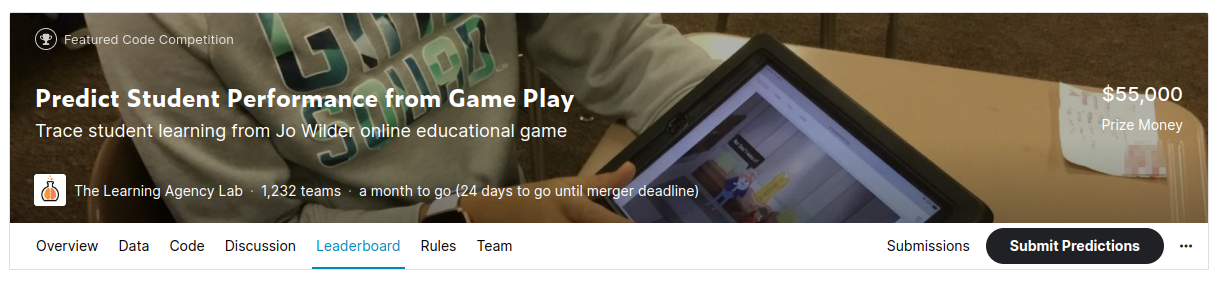
><pre>
@misc{predict-student-performance-from-game-play,
    author = {Alex Franklin, David Gagnon, HCL-Jevster, Maggie, Meg Benner, Natalie Rambis, Perpetual Baffour, Scott Crossley, ulrichboser},
    title = {Predict Student Performance from Game Play},
    publisher = {Kaggle},
    year = {2023},
    url = {https://kaggle.com/competitions/predict-student-performance-from-game-play}
}
</pre>

In [1]:
!pip3 install watermark pycaret --quiet
%load_ext watermark
%watermark -a 'NavinKumarMNK' -v -p polars,plotly,catboost,lightgbm,xgboost,pycaret

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Author: NavinKumarMNK

Python implementation: CPython
Python version       : 3.10.10
IPython version      : 8.12.0

polars  : 0.17.5
plotly  : 5.14.1
catboost: 1.1.1
lightgbm: 3.3.2
xgboost : 1.7.5
pycaret : 3.0.2



## **Modules Import**

In [2]:
import polars as pl
import pandas as pd
import os
import gc
import catboost as cb
import lightgbm as lgb
import xgboost as xgb
import plotly.express as px
from tqdm import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import GroupKFold, KFold
import warnings
import optuna
from pycaret.classification import *
warnings.filterwarnings('ignore')
from catboost import *
import numpy as np
import matplotlib.pyplot as plt
import pickle


In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/gameplay/sample_submission.csv
/kaggle/input/gameplay/train.parquet
/kaggle/input/gameplay/train_labels.csv
/kaggle/input/gameplay/test.csv
/kaggle/input/gameplay/jo_wilder_310/competition.cpython-310-x86_64-linux-gnu.so
/kaggle/input/gameplay/jo_wilder_310/__init__.py
/kaggle/input/gameplay/jo_wilder/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/gameplay/jo_wilder/__init__.py


## **Dataset**

In [4]:
train_data_path = '/kaggle/input/gameplay/train.csv'
test_data_path = '/kaggle/input/gameplay/test.csv'
submission_data_path = '/kaggle/input/gameplay/sample_submission.csv'
workspace_path = '/kaggle/input/gameplay/'
labels_path = '/kaggle/input/gameplay/train_labels.csv'

In [5]:
'''
# Run only once
# convert csv to parquet using pyarrow
import pyarrow.csv as pv
import pyarrow.parquet as pq

filename = train_data_path
table = pv.read_csv(filename)
pq.write_table(table, filename.replace('csv', 'parquet'), row_group_size=1000000)
'''

"\n# Run only once\n# convert csv to parquet using pyarrow\nimport pyarrow.csv as pv\nimport pyarrow.parquet as pq\n\nfilename = train_data_path\ntable = pv.read_csv(filename)\npq.write_table(table, filename.replace('csv', 'parquet'), row_group_size=1000000)\n"

In [6]:
train_df_par = pl.read_parquet(train_data_path.replace('csv', 'parquet'))
print(train_df_par.shape)
print(train_df_par.n_chunks())
train_df_par.head()

(26296946, 20)
27


session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
i64,i64,i64,str,str,i64,f64,f64,f64,f64,f64,f64,str,str,str,str,i64,i64,i64,str
20090312431273200,0,0,"""cutscene_click…","""basic""",0,null,-413.991405,-159.314686,380.0,494.0,null,"""undefined""","""intro""","""tunic.historic…","""tunic.historic…",0,0,1,"""0-4"""
20090312431273200,1,1323,"""person_click""","""basic""",0,null,-413.991405,-159.314686,380.0,494.0,null,"""Whatcha doing …","""gramps""","""tunic.historic…","""tunic.historic…",0,0,1,"""0-4"""
20090312431273200,2,831,"""person_click""","""basic""",0,null,-413.991405,-159.314686,380.0,494.0,null,"""Just talking t…","""gramps""","""tunic.historic…","""tunic.historic…",0,0,1,"""0-4"""
20090312431273200,3,1147,"""person_click""","""basic""",0,null,-413.991405,-159.314686,380.0,494.0,null,"""I gotta run to…","""gramps""","""tunic.historic…","""tunic.historic…",0,0,1,"""0-4"""
20090312431273200,4,1863,"""person_click""","""basic""",0,null,-412.991405,-159.314686,381.0,494.0,null,"""Can I come, Gr…","""gramps""","""tunic.historic…","""tunic.historic…",0,0,1,"""0-4"""


In [7]:
COLUMNS = []
for col in train_df_par.columns:
    COLUMNS.append(col)
    print(col, train_df_par[col].n_unique())

session_id 23562
index 20348
elapsed_time 5042639
event_name 11
name 6
level 23
page 8
room_coor_x 17441451
room_coor_y 13653975
screen_coor_x 57925
screen_coor_y 102592
hover_duration 24102
text 598
fqid 129
room_fqid 19
text_fqid 127
fullscreen 2
hq 2
music 2
level_group 3


In [8]:
columns = [
    pl.col("page").cast(pl.Int8),
    pl.col("level").cast(pl.Int8),
    pl.col("fullscreen").cast(pl.Int8),
    pl.col("hq").cast(pl.Int8),
    pl.col("music").cast(pl.Int8),
    pl.col("index").cast(pl.UInt16),
    (
        pl.when(pl.col("hover_duration").is_null())
        .then(0)
        .otherwise(1)
        .alias("is_hover")
        .cast(pl.Int8)
    ),
    (
        pl.when(pl.col("room_coor_x").is_null())
        .then(0)
        .otherwise(1)
        .alias("is_click")
        .cast(pl.Int8)
    ),
    (
        pl.when(pl.col("page").is_null())
        .then(0)
        .otherwise(1)
        .alias("is_page")
        .cast(pl.Int8)
    ),
    (
        (pl.col("elapsed_time") - pl.col("elapsed_time").shift(1))
        .fill_null(0)
        .clip(0, 1e9)
        .over(["session_id", "level"])
        .alias("elapsed_time_diff")
    ),
    (
        (pl.col("screen_coor_x") - pl.col("screen_coor_x").shift(1))
        .abs()
        .over(["session_id", "level"])
        .alias("screen_corr_x_dff")
    ),
    (
        (pl.col("screen_coor_y") - pl.col("screen_coor_y").shift(1))
        .abs()
        .over(["session_id", "level"])
        .alias("screen_corr_y_dff")
    ),
    (
        (pl.col("room_coor_x") - pl.col("room_coor_x").shift(1))
        .abs()
        .over(["session_id", "level"])
        .alias("room_corr_x_diff")
    ),
    (
        (pl.col("room_coor_y") - pl.col("room_coor_y").shift(1))
        .abs()
        .over(["session_id", "level"])
        .alias("room_corr_y_diff")
    )
]


In [9]:
df = (train_df_par.with_columns(columns))
df.head()

session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group,is_hover,is_click,is_page,elapsed_time_diff,screen_corr_x_dff,screen_corr_y_dff,room_corr_x_diff,room_corr_y_diff
i64,u16,i64,str,str,i8,i8,f64,f64,f64,f64,f64,str,str,str,str,i8,i8,i8,str,i8,i8,i8,i64,f64,f64,f64,f64
20090312431273200,0,0,"""cutscene_click…","""basic""",0,null,-413.991405,-159.314686,380.0,494.0,null,"""undefined""","""intro""","""tunic.historic…","""tunic.historic…",0,0,1,"""0-4""",0,1,0,0,null,null,null,null
20090312431273200,1,1323,"""person_click""","""basic""",0,null,-413.991405,-159.314686,380.0,494.0,null,"""Whatcha doing …","""gramps""","""tunic.historic…","""tunic.historic…",0,0,1,"""0-4""",0,1,0,1323,0.0,0.0,0.0,0.0
20090312431273200,2,831,"""person_click""","""basic""",0,null,-413.991405,-159.314686,380.0,494.0,null,"""Just talking t…","""gramps""","""tunic.historic…","""tunic.historic…",0,0,1,"""0-4""",0,1,0,0,0.0,0.0,0.0,0.0
20090312431273200,3,1147,"""person_click""","""basic""",0,null,-413.991405,-159.314686,380.0,494.0,null,"""I gotta run to…","""gramps""","""tunic.historic…","""tunic.historic…",0,0,1,"""0-4""",0,1,0,316,0.0,0.0,0.0,0.0
20090312431273200,4,1863,"""person_click""","""basic""",0,null,-412.991405,-159.314686,381.0,494.0,null,"""Can I come, Gr…","""gramps""","""tunic.historic…","""tunic.historic…",0,0,1,"""0-4""",0,1,0,716,1.0,0.0,1.0,0.0


In [11]:
df = df.with_columns([
    pl.col('fqid').apply(lambda x: 'fqid_None' if x == '' else x).alias('fqid'),
])

df = df.with_columns([
    pl.col('text_fqid').apply(lambda x: 'text_fqid_None' if x == '' else x).alias('text_fqid'),
])

df = df.with_columns([
    pl.col('page').fill_null(-1),
])

In [12]:
def extract_text_feature(df: pl.DataFrame) -> pl.DataFrame:
    dfs = []
    cc = ['question', 'exclamatory', 'comma', 'unicode']
    i = 0
    for c in ['\?', '!', ',', '\\\\u0']:
        tmp = df['text'].str.contains(c).cast(pl.UInt8).rename(f"text_{cc[i]}")
        dfs.append(tmp)
        i+=1

    tmp_full_stop = df['text'].str.contains(r'\.').cast(pl.UInt8).rename("text_full_stop")
    tmp_ellipsis = df['text'].str.contains(r'\.\.\.').cast(pl.UInt8).rename("text_ellipsis")

    dfs.append(tmp_full_stop)
    dfs.append(tmp_ellipsis)

    tmp = df['text'].str.n_chars().eq(0).cast(pl.UInt8).rename("text_empty")

    dfs = pl.DataFrame(dfs)
    dfs = pl.concat([df, dfs], how="horizontal")
    return dfs

sample_df = extract_text_feature(df)
sample_df.head()

session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group,is_hover,is_click,is_page,elapsed_time_diff,screen_corr_x_dff,screen_corr_y_dff,room_corr_x_diff,room_corr_y_diff,text_question,text_exclamatory,text_comma,text_unicode,text_full_stop,text_ellipsis
i64,u16,i64,str,str,i8,i8,f64,f64,f64,f64,f64,str,str,str,str,i8,i8,i8,str,i8,i8,i8,i64,f64,f64,f64,f64,u8,u8,u8,u8,u8,u8
20090312431273200,0,0,"""cutscene_click…","""basic""",0,-1,-413.991405,-159.314686,380.0,494.0,null,"""undefined""","""intro""","""tunic.historic…","""tunic.historic…",0,0,1,"""0-4""",0,1,0,0,null,null,null,null,0,0,0,0,0,0
20090312431273200,1,1323,"""person_click""","""basic""",0,-1,-413.991405,-159.314686,380.0,494.0,null,"""Whatcha doing …","""gramps""","""tunic.historic…","""tunic.historic…",0,0,1,"""0-4""",0,1,0,1323,0.0,0.0,0.0,0.0,1,0,1,0,0,0
20090312431273200,2,831,"""person_click""","""basic""",0,-1,-413.991405,-159.314686,380.0,494.0,null,"""Just talking t…","""gramps""","""tunic.historic…","""tunic.historic…",0,0,1,"""0-4""",0,1,0,0,0.0,0.0,0.0,0.0,0,0,0,0,1,0
20090312431273200,3,1147,"""person_click""","""basic""",0,-1,-413.991405,-159.314686,380.0,494.0,null,"""I gotta run to…","""gramps""","""tunic.historic…","""tunic.historic…",0,0,1,"""0-4""",0,1,0,316,0.0,0.0,0.0,0.0,0,1,0,0,0,0
20090312431273200,4,1863,"""person_click""","""basic""",0,-1,-412.991405,-159.314686,381.0,494.0,null,"""Can I come, Gr…","""gramps""","""tunic.historic…","""tunic.historic…",0,0,1,"""0-4""",0,1,0,716,1.0,0.0,1.0,0.0,1,0,1,0,0,0


In [13]:
print(
    sample_df['text_question'].value_counts(),
    sample_df['text_comma'].value_counts(),
    sample_df['text_exclamatory'].value_counts(),
    sample_df['text_full_stop'].value_counts(),
    sample_df['text_unicode'].value_counts(),
    sample_df['text_ellipsis'].value_counts(),
)

shape: (2, 2)
┌───────────────┬──────────┐
│ text_question ┆ counts   │
│ ---           ┆ ---      │
│ u8            ┆ u32      │
╞═══════════════╪══════════╡
│ 0             ┆ 24074710 │
│ 1             ┆ 2222236  │
└───────────────┴──────────┘ shape: (2, 2)
┌────────────┬──────────┐
│ text_comma ┆ counts   │
│ ---        ┆ ---      │
│ u8         ┆ u32      │
╞════════════╪══════════╡
│ 0          ┆ 24241967 │
│ 1          ┆ 2054979  │
└────────────┴──────────┘ shape: (2, 2)
┌──────────────────┬──────────┐
│ text_exclamatory ┆ counts   │
│ ---              ┆ ---      │
│ u8               ┆ u32      │
╞══════════════════╪══════════╡
│ 0                ┆ 22080902 │
│ 1                ┆ 4216044  │
└──────────────────┴──────────┘ shape: (2, 2)
┌────────────────┬──────────┐
│ text_full_stop ┆ counts   │
│ ---            ┆ ---      │
│ u8             ┆ u32      │
╞════════════════╪══════════╡
│ 0              ┆ 22084432 │
│ 1              ┆ 4212514  │
└────────────────┴──────────┘ shape: (

In [14]:
print(sample_df['text'].value_counts())

shape: (598, 2)
┌───────────────────────────────────┬────────┐
│ text                              ┆ counts │
│ ---                               ┆ ---    │
│ str                               ┆ u32    │
╞═══════════════════════════════════╪════════╡
│ See you later, Teddy.             ┆ 11658  │
│ Where are the Stacks?             ┆ 23926  │
│ Nope, that's from Bean Town. I o… ┆ 23707  │
│ It'll be okay, Jo. We'll find Te… ┆ 1      │
│ …                                 ┆ …      │
│ I wonder if there's a clue in th… ┆ 13     │
│ Well, I did SOME of those. I jus… ┆ 6565   │
│ Better check back later.          ┆ 14202  │
│ Actually, I went to school with … ┆ 23837  │
└───────────────────────────────────┴────────┘


In [15]:
CATS = ['event_name', 'name', 'fqid', 'room_fqid', 'text_fqid', 'level', 'page'] 
NUMS = ['room_coor_x', 'room_coor_y', 'screen_coor_x', 
        'screen_coor_y', 'hover_duration', 'elapsed_time_diff',
        'screen_corr_x_dff', 'screen_corr_y_dff', 'room_corr_x_diff', 'room_corr_y_diff']
SNO = ['session_id', 'index']
LEVEL = {
    '0-4'  : [0, 1, 2, 3, 4],
    '5-12' : [5, 6, 7, 8, 9, 10, 11, 12],
    '13-22': [13, 14, 15, 16, 17, 18, 19, 20, 21, 22],
}
DATE = [ 'year', 'month', 'day', 'hour', 'minute', 'second']
DUO = ['fullscreen', 'hq', 'music', "is_click", "is_page", "is_hover"]
TEXT = ["text_\?", "text_!", "text_,", "text_\\u0", "text_\."]

In [16]:
df = sample_df
df.null_count()

session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group,is_hover,is_click,is_page,elapsed_time_diff,screen_corr_x_dff,screen_corr_y_dff,room_corr_x_diff,room_corr_y_diff,text_question,text_exclamatory,text_comma,text_unicode,text_full_stop,text_ellipsis
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,2073272,2073272,2073272,2073272,24294702,0,0,0,0,0,0,0,0,0,0,0,0,3773981,3773981,3773981,3773981,0,0,0,0,0,0


In [17]:
ques_level = {
    '0-4'   : [1, 2, 3],
    '5-12'  : [4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
    '13-22' : [14, 15, 16, 17, 18]
}

In [18]:
# UNIQUE FEATURES
EVENT_NAME = df['event_name'].unique().to_pandas().to_list()
NAME = df['name'].unique().to_pandas().to_list()
FQID = df['fqid'].unique().to_pandas().to_list()
ROOM_FQID = df['room_fqid'].unique().to_pandas().to_list()
TEXT_FQID = df['text_fqid'].unique().to_pandas().to_list()
LEVEL = df['level'].unique().to_pandas().to_list()
PAGE = df['page'].unique().to_pandas().to_list()

print(EVENT_NAME, len(EVENT_NAME), end="\n\n")
print(NAME, len(NAME), end="\n\n")
print(FQID, len(FQID), end="\n\n")
print(ROOM_FQID, len(ROOM_FQID), end="\n\n")
print(TEXT_FQID, len(TEXT_FQID), end="\n\n")
print(LEVEL, len(LEVEL), end="\n\n")
print(PAGE, len(PAGE), end="\n\n")

['object_click', 'person_click', 'notification_click', 'map_hover', 'notebook_click', 'object_hover', 'observation_click', 'cutscene_click', 'checkpoint', 'navigate_click', 'map_click'] 11

['open', 'basic', 'undefined', 'close', 'prev', 'next'] 6

['block_tocollection', 'tocloset_dirty', 'block_magnify', 'reader', 'tomap', 'tunic.capitol_2', 'chap2_finale_c', 'chap2_finale', 'reader_flag.paper1.prev', 'journals_flag.hub.topics', 'teddy', 'tunic.kohlcenter', 'chap1_finale', 'block_badge', 'reader_flag.paper2.next', 'businesscards.card_0.next', 'logbook.page.bingo', 'seescratches', 'glasses', 'reader.paper2.next', 'journals_flag.pic_0.bingo', 'tracks.hub.deer', 'tobasement', 'photo', 'tunic.drycleaner', 'wellsbadge', 'colorbook', 'magnify', 'reader_flag.paper0.prev', 'tunic.flaghouse', 'trigger_scarf', 'fox', 'block_tomap2', 'journals_flag.pic_0.next', 'journals_flag.pic_2.bingo', 'plaque', 'door_block_clean', 'groupconvo_flag', 'reader.paper1.next', 'crane_ranger', 'lockeddoor', 'need_

In [19]:
"""
Transforming that done irrespective of the group_level.
"""
def model_data_1(x:pl.DataFrame, group:str, index:str="session_id"):
    aggs = [pl.col("index").count().alias(f"session_number")]
    for cat in CATS:
        aggs.extend([
            pl.col(cat)
              .filter(pl.col(cat) == c)
              .count()
              .alias(f"{c}_{cat}_counts")
              for c in x[cat].unique().to_pandas().to_list()
             ])
    for bi in DUO:
        aggs.extend([
            pl.col(bi)
            .filter(pl.col(bi) == c)
            .count()
            .alias(f"{c}_{bi}_counts")
            for c in x[bi].unique().to_pandas().to_list()
        ])
    for num in NUMS:
        aggs.extend([
            pl.col(num)
            .std()
            .alias(f"{num}_std")
        ])
        aggs.extend([
            pl.col(num)
            .mean()
            .alias(f"{num}_mean")
        ])
        aggs.extend([
            pl.col(num)
            .sum()
            .alias(f"{num}_sum")
        ])
    
    for num in list(filter(lambda x: x not in 
                ['elapsed_time_diff', 'screen_corr_x_dff', 'screen_corr_y_dff', 
                 'room_corr_x_diff', 'room_corr_y_diff'], NUMS)):
        aggs.extend([
            pl.col(num)
            .max()
            .alias(f"{num}_max")
        ])
        aggs.extend([
            pl.col(num)
            .min()
            .alias(f"{num}_min")
        ])
    
    x = x.groupby([index, group]).agg(aggs).sort("session_id")
    x = x.drop(['0_hq_counts', '0_music_counts', '0_fullscreen_counts',
                '0_is_click_counts', '0_is_page_counts', '0_is_hover_counts',
                group]
              )
    x = x.rename({
            "1_fullscreen_counts" : "is_fullscreen",
            "1_hq_counts" : "is_hq",
            "1_music_counts" : "is_music",
            "1_is_click_counts" : "click_counts",
            "1_is_page_counts" : "page_counts",
            "1_is_hover_counts" : "hover_counts"
        })
    
    x = x.with_columns(
        pl.col(['is_hq']).gt(1).cast(pl.UInt8),
        pl.col(['is_fullscreen']).gt(1).cast(pl.UInt8),
        pl.col(['is_music']).gt(1).cast(pl.UInt8),
        pl.col('session_id').apply(lambda x: int(str(x)[:2])).cast(pl.UInt8).alias('year'),
        pl.col('session_id').apply(lambda x: int(str(x)[2:4])+1).cast(pl.UInt8).alias('month'),
        pl.col('session_id').apply(lambda x: int(str(x)[4:6])).cast(pl.UInt8).alias('day'),
        pl.col('session_id').apply(lambda x: int(str(x)[6:8])).cast(pl.UInt8).alias('hour'),
        #pl.col('session_id').apply(lambda x: int(str(x)[8:10])).cast(pl.Int8).alias('minute'),
        #pl.col('session_id').apply(lambda x: int(str(x)[10:12])).cast(pl.Int8).alias('second'),
    )
    x = x.to_pandas()
    x.set_index(index)
    return x 

In [20]:
#sample_df = model_data_1(df.filter(pl.col("level") == 5), "level", "session_id")
#sample_df

sample_df = model_data_1(df.filter(pl.col("level_group") == '13-22'),
                         "level_group", "session_id")
sample_df

,session_id,session_number,checkpoint_event_name_counts,person_click_event_name_counts,notification_click_event_name_counts,object_hover_event_name_counts,observation_click_event_name_counts,map_click_event_name_counts,cutscene_click_event_name_counts,navigate_click_event_name_counts,...,screen_coor_x_max,screen_coor_x_min,screen_coor_y_max,screen_coor_y_min,hover_duration_max,hover_duration_min,year,month,day,hour
0,20090312431273200,420,1,123,10,13,3,6,60,170,...,859.0,2.0,659.0,24.0,4750.0,17.0,20,10,3,12
1,20090312433251036,1297,1,145,14,66,5,45,65,637,...,878.0,0.0,657.0,29.0,22351.0,14.0,20,10,3,12
2,20090312455206810,364,1,101,6,13,3,10,58,123,...,1193.0,6.0,898.0,41.0,4568.0,16.0,20,10,3,12
3,20090313091715820,491,1,110,11,17,4,7,66,234,...,1011.0,10.0,746.0,36.0,8258.0,16.0,20,10,3,13
4,20090313571836404,392,1,107,8,11,5,9,55,171,...,870.0,2.0,648.0,49.0,7700.0,16.0,20,10,3,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23557,22100215342220508,424,1,109,8,22,4,7,59,169,...,872.0,20.0,642.0,60.0,54092814.0,16.0,22,11,2,15
23558,22100215460321130,454,1,135,8,12,5,13,70,148,...,934.0,11.0,693.0,32.0,6328.0,17.0,22,11,2,15
23559,22100217104993650,610,1,127,11,17,4,8,75,278,...,871.0,4.0,646.0,27.0,9464.0,17.0,22,11,2,17
23560,22100219442786200,423,1,101,8,11,5,8,54,181,...,873.0,4.0,653.0,34.0,5270.0,16.0,22,11,2,19


## **Model**

In [21]:
CATBOOST_CATS = ['year', 'month', 'day', 'hour', "is_fullscreen", "is_hq", "is_music"]

In [22]:
targets = pd.read_csv(labels_path)
targets['session'] = targets.session_id.apply(lambda x: int(x.split("_")[0]))
targets['q'] = targets.session_id.apply(lambda x: int(x.split("_")[1][1:]))
targets

,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1
3,20090313091715820_q1,0,20090313091715820,1
4,20090313571836404_q1,1,20090313571836404,1
...,...,...,...,...
424111,22100215342220508_q18,1,22100215342220508,18
424112,22100215460321130_q18,1,22100215460321130,18
424113,22100217104993650_q18,1,22100217104993650,18
424114,22100219442786200_q18,1,22100219442786200,18


In [23]:
for i in range(1, 19):
    print(targets[targets['q'] ==i]['correct'].value_counts().to_list())

[17141, 6421]
[23063, 499]
[22007, 1555]
[18808, 4754]
[12918, 10644]
[18283, 5279]
[17343, 6219]
[14543, 9019]
[17348, 6214]
[11909, 11653]
[15165, 8397]
[20333, 3229]
[17080, 6482]
[16674, 6888]
[12228, 11334]
[17315, 6247]
[16206, 7356]
[22399, 1163]


In [24]:
ques_target = []
ques_name = []
for i in range(1, 19):
    ques_target.append(targets[targets['q']==i].correct.to_list())
    ques_name.append(f"ques_{i}")

In [25]:
'''
## Run only Once For Exporting
for q in tqdm(range(1, 19)):
    if q <= 3:
        grp = '0-4'
    elif q <= 13:
        grp = '5-12'
    elif q <= 22:
        grp = '13-22'
        
    main_df = model_data_1(df.filter(pl.col("level_group") == grp),
                         "level_group", "session_id")
    
    for j in range(q-1):
        main_df[ques_name[j]] = ques_target[j]

    main_df['target'] = ques_target[q-1]
    main_df['group'] = main_df['session_id']
    
    main_df.to_parquet(f"data_ques_{q}.parquet")
'''

'\n## Run only Once For Exporting\nfor q in tqdm(range(1, 19)):\n    if q <= 3:\n        grp = \'0-4\'\n    elif q <= 13:\n        grp = \'5-12\'\n    elif q <= 22:\n        grp = \'13-22\'\n        \n    main_df = model_data_1(df.filter(pl.col("level_group") == grp),\n                         "level_group", "session_id")\n    \n    for j in range(q-1):\n        main_df[ques_name[j]] = ques_target[j]\n\n    main_df[\'target\'] = ques_target[q-1]\n    main_df[\'group\'] = main_df[\'session_id\']\n    \n    main_df.to_parquet(f"data_ques_{q}.parquet")\n'

In [26]:
df1 = model_data_1(df.filter(pl.col("level_group") == '0-4'),
                         "level_group", "session_id")
df2 = model_data_1(df.filter(pl.col("level_group") == '5-12'),
                         "level_group", "session_id")
df3 = model_data_1(df.filter(pl.col("level_group") == '13-22'),
                         "level_group", "session_id")

In [27]:
df1

,session_id,session_number,person_click_event_name_counts,observation_click_event_name_counts,notification_click_event_name_counts,object_click_event_name_counts,cutscene_click_event_name_counts,object_hover_event_name_counts,map_click_event_name_counts,checkpoint_event_name_counts,...,screen_coor_x_max,screen_coor_x_min,screen_coor_y_max,screen_coor_y_min,hover_duration_max,hover_duration_min,year,month,day,hour
0,20090312431273200,165,22,4,8,11,28,4,2,1,...,843.0,11.0,639.0,60.0,7899.0,17.0,20,10,3,12
1,20090312433251036,139,18,2,5,15,36,5,3,1,...,875.0,0.0,639.0,58.0,5567.0,17.0,20,10,3,12
2,20090312455206810,149,18,0,9,10,49,1,2,1,...,1189.0,1.0,706.0,30.0,8401.0,51.0,20,10,3,12
3,20090313091715820,176,22,2,8,18,34,5,2,1,...,1006.0,2.0,750.0,6.0,5794.0,216.0,20,10,3,13
4,20090313571836404,112,19,0,8,9,26,5,3,1,...,878.0,6.0,616.0,36.0,4383.0,16.0,20,10,3,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23557,22100215342220508,150,21,3,9,13,29,8,2,1,...,865.0,19.0,652.0,44.0,17093.0,17.0,22,11,2,15
23558,22100215460321130,149,21,1,9,19,31,5,2,1,...,930.0,37.0,682.0,48.0,5248.0,16.0,22,11,2,15
23559,22100217104993650,197,23,4,11,15,28,6,2,1,...,862.0,2.0,652.0,33.0,5664.0,17.0,22,11,2,17
23560,22100219442786200,167,20,1,8,9,32,5,3,1,...,849.0,29.0,618.0,22.0,7087.0,349.0,22,11,2,19


## **Question 1**

In [92]:
def objective_cat(trial, q):
    global df
    ALL_USERS = df['session_id'].unique()
    feature_importance_df = pd.DataFrame()
    models = {}
    results = [[[], []]]
    gkf = GroupKFold(n_splits=5)
    oof_cat = pd.DataFrame(data=np.zeros((len(ALL_USERS),1)), index=ALL_USERS, 
                           columns=[f'meta_{i}' for i in range(1, 2)])
    if q <= 3:
        grp = '0-4'
        df = df1

    elif q <= 13:
        grp = '5-12'
        df = df2

    elif q <= 22:
        grp = '13-22'
        df = df3

    FEATURES = df.columns
    df.set_index('session_id')
    print("-"*50)
    print(f'question{q}, with{len(FEATURES)}features')
    print('-'*50)

    cat_params = {
        'iterations': 5000,
        'early_stopping_rounds': 75,
        'depth': trial.suggest_int('depth', 5, 8),
        'learning_rate': 0.003,
        'loss_function': "Logloss",
        'random_seed': 222222,
        'metric_period': 1,
        'subsample': trial.suggest_float('subsample', 0.5, 0.75),
        'colsample_bylevel': trial.suggest_float('subsample', 0.4, 0.6),
        'verbose': 0,
        'l2_leaf_reg': 20,
    }

    feature_importance_df = pd.DataFrame()


    for fold, (train_idx, valid_idx) in enumerate(gkf.split(X=df, groups=df.index)):
        # TRAIN DATA
        train_x = df.iloc[train_idx]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q == q].reset_index().loc[train_users]

        # VALID DATA
        valid_x = df.iloc[valid_idx]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets.q == q].reset_index().loc[valid_users]

        train_pool = Pool(train_x[FEATURES].astype('float32'), train_y['correct'])
        valid_pool = Pool(valid_x[FEATURES].astype('float32'), valid_y['correct'])


        model = CatBoostClassifier(**cat_params)
        model = model.fit(train_pool, eval_set=valid_pool)

        y = valid_pool.get_label()
        y_hat = model.predict_proba(valid_pool)[:,1]
        models[(fold, q)] = model

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = FEATURES
        fold_importance_df["importance"] = model.feature_importances_
        fold_importance_df["fold"] = fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        results[q - 1][0].append(y)
        results[q - 1][1].append(y_hat)
    feature_importance_df = feature_importance_df.groupby(['feature'])['importance'].agg(['mean']).sort_values(by='mean', ascending=False)
    display(feature_importance_df.head(10))

    results = [[np.concatenate(_) for _ in _] for _ in results]
    print(results)
    
    for (fold,q), model in models.items():
        with open(f'cat_fold{fold}_q{q}.pkl', 'wb') as f:
            pickle.dump(model, f)

    true = pd.DataFrame(results[0][0])
    oof = pd.DataFrame(results[0][1])
    scores = []; thresholds = []
    best_socre = 0; best_threshold = 0

    for threshold in np.arange(0.5, 0.7, 0.01):
        preds = (oof.values.reshape(-1) > threshold).astype('int')
        m = f1_score(true.values.reshape(-1), preds, average='macro')
        scores.append(m)
        thresholds.append(threshold)
        if m > best_socre:
            best_socre = m
            best_threshold = threshold

    plt.figure(figsize=(20, 5))
    plt.plot(thresholds, scores, '-o', color='blue')
    plt.scatter([best_threshold], [best_socre], color='blue')
    plt.xlabel("Threshold", size=14)
    plt.ylabel("Validation F1 Score",size=14)
    plt.title(f'Threshold vs. F1_Score with Best F1_Score={best_socre:.3f} at Best Threshold = {best_threshold:.3}', size=18)
    plt.show()

    print(f'When using optimal threshold = {best_threshold:.2f}...')
    m = f1_score(true.values.reshape(-1), (oof.values > best_threshold).reshape(-1).astype('int'), average = 'macro')
    print('==> Overall F1 =', m)
    print('s')
    return m


[I 2023-05-22 17:22:51,586] A new study created in memory with name: no-name-81404b7e-9d59-466e-97f7-52c63e6b8e5d
  0%|          | 0/1 [00:00<?, ?it/s]

--------------------------------------------------
question1, with148features
--------------------------------------------------


,mean
feature,
elapsed_time_diff_std,11.857934
plaque_fqid_counts,3.271391
elapsed_time_diff_mean,3.219537
basic_name_counts,2.133045
tunic.historicalsociety.collection_room_fqid_counts,2.031900
directory_fqid_counts,1.847439
elapsed_time_diff_sum,1.802217
tunic.capitol_0.hall_room_fqid_counts,1.657232
report_fqid_counts,1.657095


100%|██████████| 1/1 [15:52<00:00, 952.31s/it]


[[array([0, 1, 1, ..., 1, 1, 0]), array([0.7213679 , 0.58206639, 0.60692618, ..., 0.81788319, 0.89250684,
       0.6479353 ])]]


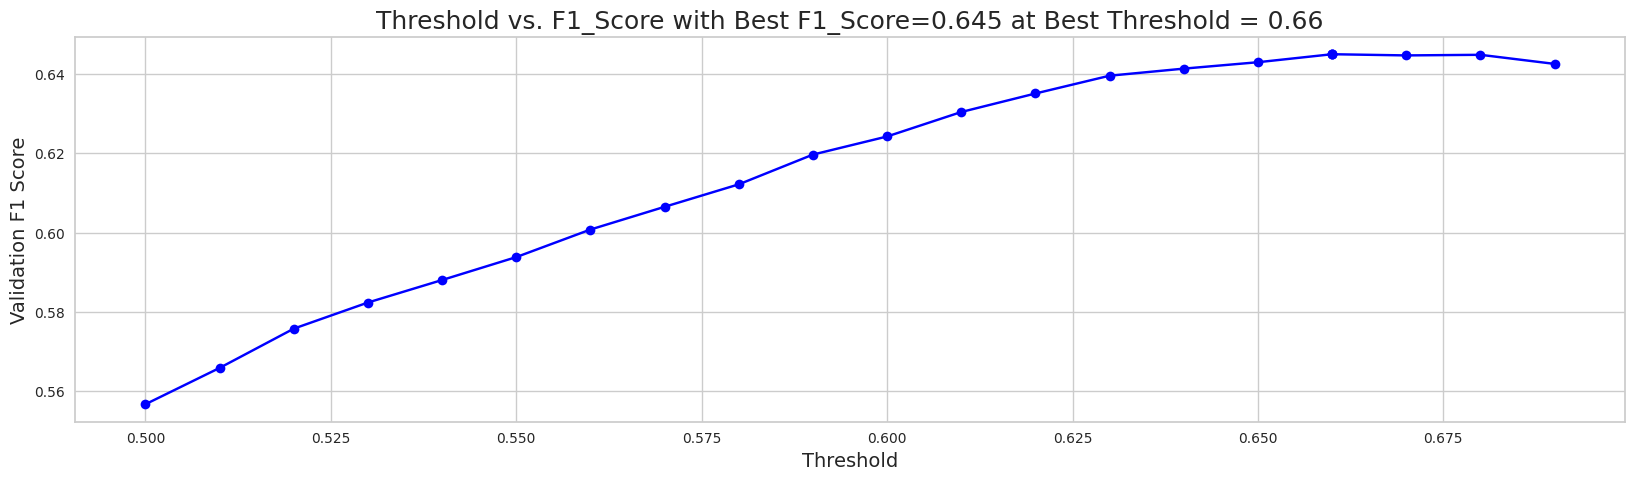

[I 2023-05-22 17:38:44,567] Trial 0 finished with value: 0.6450338814698933 and parameters: {'depth': 8, 'subsample': 0.627881930975636}. Best is trial 0 with value: 0.6450338814698933.


When using optimal threshold = 0.66...
Q0: F1 = 0.6450338814698933
==> Overall F1 = 0.6450338814698933
s


  0%|          | 0/1 [00:00<?, ?it/s]

--------------------------------------------------
question1, with148features
--------------------------------------------------


,mean
feature,
elapsed_time_diff_std,16.465572
plaque_fqid_counts,4.363945
elapsed_time_diff_mean,3.957979
basic_name_counts,3.286269
tunic.historicalsociety.collection_room_fqid_counts,2.618982
directory_fqid_counts,2.145118
elapsed_time_diff_sum,1.984624
report_fqid_counts,1.964992
tunic.capitol_0.hall_room_fqid_counts,1.898467


100%|██████████| 1/1 [07:32<00:00, 452.81s/it]


[[array([0, 1, 1, ..., 1, 1, 0]), array([0.7497585 , 0.56135232, 0.60774427, ..., 0.8232342 , 0.8908665 ,
       0.6288347 ])]]


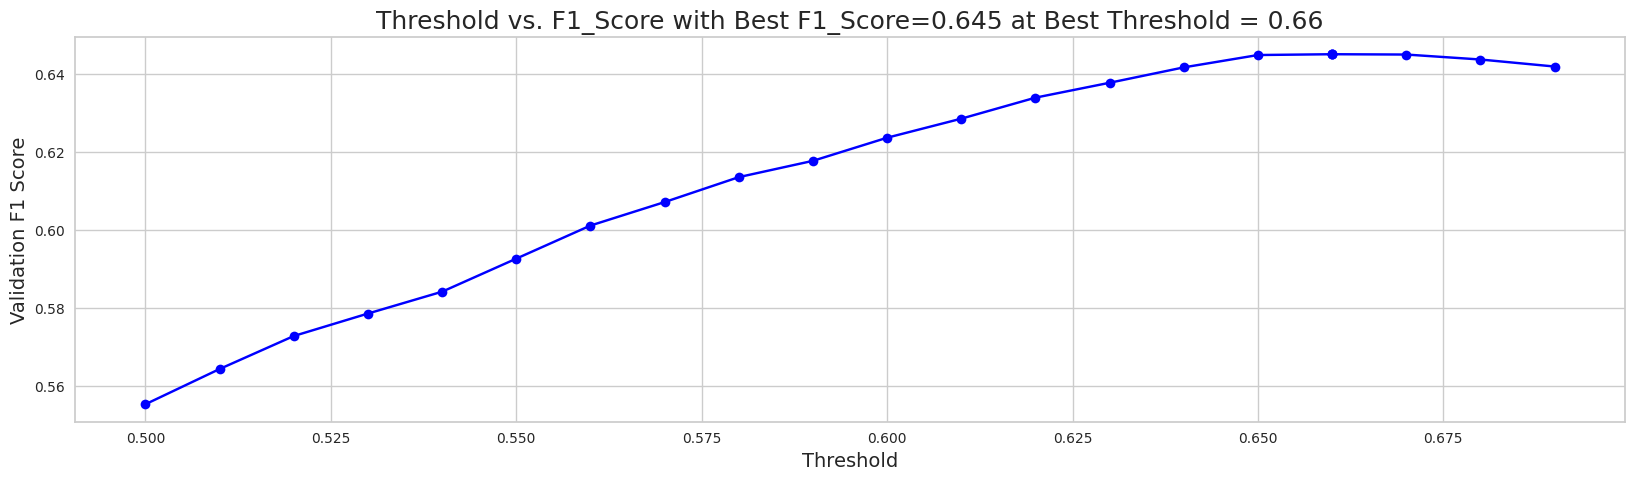

[I 2023-05-22 17:46:17,923] Trial 1 finished with value: 0.6450995487021642 and parameters: {'depth': 6, 'subsample': 0.6504570471462586}. Best is trial 1 with value: 0.6450995487021642.


When using optimal threshold = 0.66...
Q0: F1 = 0.6450995487021642
==> Overall F1 = 0.6450995487021642
s


  0%|          | 0/1 [00:00<?, ?it/s]

--------------------------------------------------
question1, with148features
--------------------------------------------------


In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_cat, n_trials=1000, args=(1))

# Get the best hyperparameters
best_params = study.best_params
print(best_params)

In [88]:
def objective_lgbm(trial, aaa):
    global df
    ALL_USERS = df['session_id'].unique()
    feature_importance_df = pd.DataFrame()
    models = {}
    results = [[[], []]]
    gkf = GroupKFold(n_splits=5)
    oof_cat = pd.DataFrame(data=np.zeros((len(ALL_USERS),1)), index=ALL_USERS, 
                           columns=[f'meta_{i}' for i in range(1, 2)])
    for q in tqdm(range(aaa, aaa+1)):
        if q <= 3:
            grp = '0-4'
            df = df1

        elif q <= 13:
            grp = '5-12'
            df = df2

        elif q <= 22:
            grp = '13-22'
            df = df3

        FEATURES = df.columns
        df.set_index('session_id')
        print("-"*50)
        print(f'question{q}, with{len(FEATURES)}features')
        print('-'*50)

        lgbm_params = {
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': 'binary_logloss',
            'num_iterations': 1,
            'early_stopping_rounds': 75,
            'max_depth': trial.suggest_int('depth', 5, 8),
            'learning_rate': 0.003,
            'subsample': trial.suggest_float('subsample', 0.5, 0.8),
            'colsample_bytree': trial.suggest_float('subsample', 0.4, 0.6),
            'random_seed': 222222,
            'verbose': -1,
            'lambda_l2': 20,
        }

        feature_importance_df = pd.DataFrame()

        for fold, (train_idx, valid_idx) in enumerate(gkf.split(X=df, groups=df.index)):
            # TRAIN DATA
            train_x = df.iloc[train_idx]
            train_users = train_x.index.values
            train_y = targets.loc[targets.q == q].reset_index().loc[train_users]

            # VALID DATA
            valid_x = df.iloc[valid_idx]
            valid_users = valid_x.index.values
            valid_y = targets.loc[targets.q == q].reset_index().loc[valid_users]

            model = lgb.LGBMClassifier(**lgbm_params)
            model = model.fit(train_x[FEATURES], train_y['correct'],
                  eval_set=[(valid_x[FEATURES], valid_y['correct'])],
                  early_stopping_rounds=lgbm_params['early_stopping_rounds'],
                  verbose=False)


            y = valid_y['correct']
            y_hat = model.predict_proba(valid_x[FEATURES])
            models[(fold, q)] = model

            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = FEATURES
            fold_importance_df["importance"] = model.feature_importances_
            fold_importance_df["fold"] = fold + 1
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)


            results[q - 1][0].append(y)
            results[q - 1][1].append(y_hat)
        feature_importance_df = feature_importance_df.groupby(['feature'])['importance'].agg(['mean']).sort_values(by='mean', ascending=False)
        display(feature_importance_df.head(10))
    results = [[np.concatenate(_) for _ in _] for _ in results]
    print(results)
    
    
    for (fold,q), model in models.items():
        with open(f'lgbm_fold{fold}_q{q}.pkl', 'wb') as f:
            pickle.dump(model, f)

    true = pd.DataFrame(results[0][0])
    print(results[0][1])
    
    oof = pd.DataFrame(results[0][1][:, 1])
    
    scores = []; thresholds = []
    best_socre = 0; best_threshold = 0

    for threshold in np.arange(0.5, 0.7, 0.01):
        preds = (oof.values.reshape(-1) > threshold).astype('int')
        m = f1_score(true.values.reshape(-1), preds, average='macro')
        scores.append(m)
        thresholds.append(threshold)
        if m > best_socre:
            best_socre = m
            best_threshold = threshold

    plt.figure(figsize=(20, 5))
    plt.plot(thresholds, scores, '-o', color='blue')
    plt.scatter([best_threshold], [best_socre], color='blue')
    plt.xlabel("Threshold", size=14)
    plt.ylabel("Validation F1 Score",size=14)
    plt.title(f'Threshold vs. F1_Score with Best F1_Score={best_socre:.3f} at Best Threshold = {best_threshold:.3}', size=18)
    plt.show()

    print(f'When using optimal threshold = {best_threshold:.2f}...')
    for k in range(1):
        m = f1_score(true[k].values, (oof[k].values > best_threshold).astype('int'), average = 'macro')
        print(f'Q{k}: F1 =',m)
    m = f1_score(true.values.reshape(-1), (oof.values > best_threshold).reshape(-1).astype('int'), average = 'macro')
    print('==> Overall F1 =', m)
    print('s')
    return m



[I 2023-05-22 17:21:52,044] A new study created in memory with name: no-name-19a7223f-7076-4edf-be86-dbcce5243963
  0%|          | 0/1 [00:00<?, ?it/s]

--------------------------------------------------
question1, with148features
--------------------------------------------------
[LightGBM] [Warning] early_stopping_round is set=75, early_stopping_rounds=75 will be ignored. Current value: early_stopping_round=75
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] early_stopping_round is set=75, early_stopping_rounds=75 will be ignored. Current value: early_stopping_round=75
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] early_stopping_round is set=75, early_stopping_rounds=75 will be ignored. Current value: early_stopping_round=75
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] early_stopping_round is set=75, early_stopping_rounds=75 will be ignored. Current value: early_stopping_round=75
[LightGBM] [Warning] lambda_l

,mean
feature,
elapsed_time_diff_std,8.2
plaque_fqid_counts,3.0
tunic.historicalsociety.collection_room_fqid_counts,2.4
click_counts,2.0
tunic.historicalsociety.entry.groupconvo_text_fqid_counts,1.8
gramps_fqid_counts,1.4
elapsed_time_diff_sum,1.4
directory_fqid_counts,1.0
cutscene_click_event_name_counts,1.0


100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


[[array([0, 1, 1, ..., 1, 1, 0]), array([[0.27016796, 0.72983204],
       [0.27052109, 0.72947891],
       [0.26998933, 0.73001067],
       ...,
       [0.27073174, 0.72926826],
       [0.27073174, 0.72926826],
       [0.27105018, 0.72894982]])]]
[[0.27016796 0.72983204]
 [0.27052109 0.72947891]
 [0.26998933 0.73001067]
 ...
 [0.27073174 0.72926826]
 [0.27073174 0.72926826]
 [0.27105018 0.72894982]]


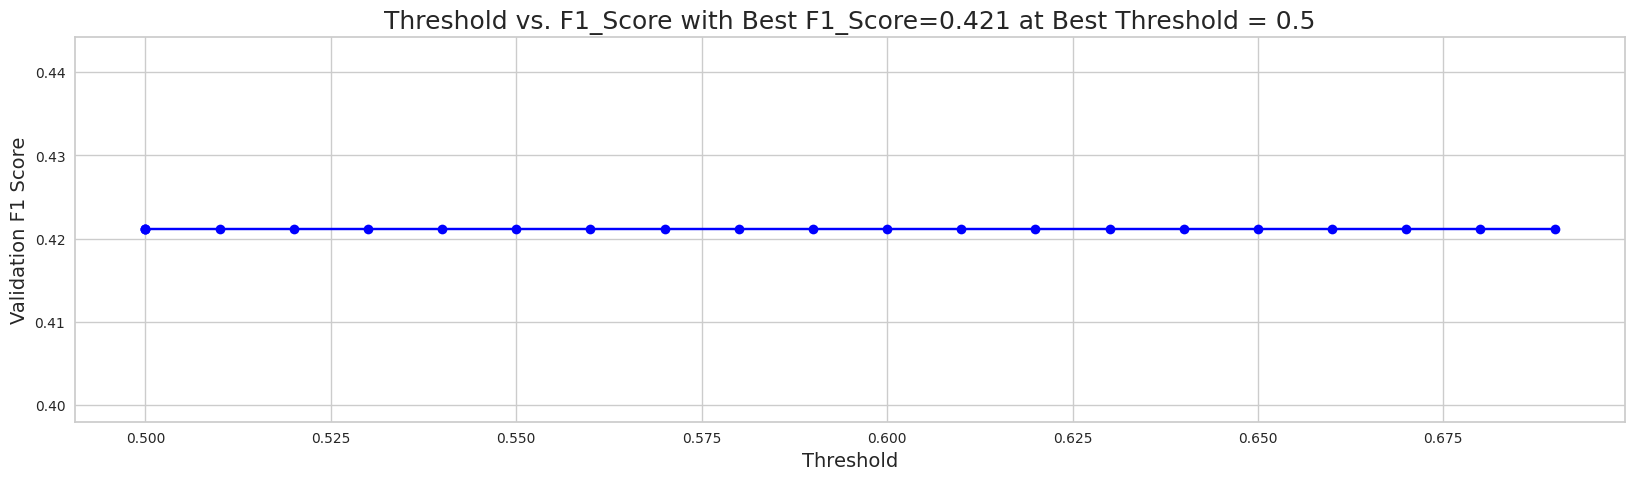

[I 2023-05-22 17:21:54,135] Trial 0 finished with value: 0.4211237500921308 and parameters: {'depth': 7, 'subsample': 0.610806783653284}. Best is trial 0 with value: 0.4211237500921308.


When using optimal threshold = 0.50...
Q0: F1 = 0.4211237500921308
==> Overall F1 = 0.4211237500921308
s


  0%|          | 0/1 [00:00<?, ?it/s]

--------------------------------------------------
question1, with148features
--------------------------------------------------
[LightGBM] [Warning] early_stopping_round is set=75, early_stopping_rounds=75 will be ignored. Current value: early_stopping_round=75
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] early_stopping_round is set=75, early_stopping_rounds=75 will be ignored. Current value: early_stopping_round=75
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] early_stopping_round is set=75, early_stopping_rounds=75 will be ignored. Current value: early_stopping_round=75
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] early_stopping_round is set=75, early_stopping_rounds=75 will be ignored. Current value: early_stopping_round=75
[LightGBM] [Warning] lambda_l

,mean
feature,
elapsed_time_diff_std,8.2
tunic.historicalsociety.collection_room_fqid_counts,2.6
plaque_fqid_counts,2.6
tunic.historicalsociety.entry.groupconvo_text_fqid_counts,1.8
click_counts,1.6
gramps_fqid_counts,1.2
tunic.capitol_0.hall_room_fqid_counts,1.0
elapsed_time_diff_sum,1.0
cutscene_click_event_name_counts,1.0


100%|██████████| 1/1 [00:01<00:00,  1.60s/it]


[[array([0, 1, 1, ..., 1, 1, 0]), array([[0.27016796, 0.72983204],
       [0.27052109, 0.72947891],
       [0.26998933, 0.73001067],
       ...,
       [0.27073174, 0.72926826],
       [0.27073174, 0.72926826],
       [0.27105018, 0.72894982]])]]
[[0.27016796 0.72983204]
 [0.27052109 0.72947891]
 [0.26998933 0.73001067]
 ...
 [0.27073174 0.72926826]
 [0.27073174 0.72926826]
 [0.27105018 0.72894982]]


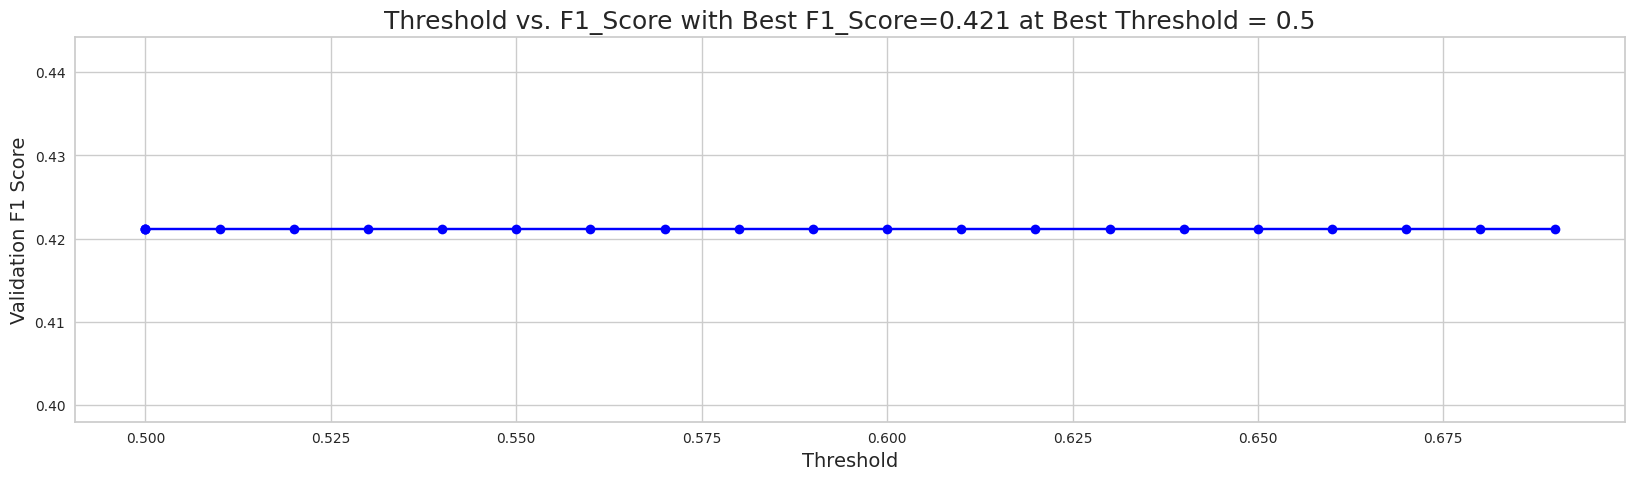

[I 2023-05-22 17:21:56,309] Trial 1 finished with value: 0.4211237500921308 and parameters: {'depth': 7, 'subsample': 0.7788450631931082}. Best is trial 0 with value: 0.4211237500921308.


When using optimal threshold = 0.50...
Q0: F1 = 0.4211237500921308
==> Overall F1 = 0.4211237500921308
s


  0%|          | 0/1 [00:00<?, ?it/s]

--------------------------------------------------
question1, with148features
--------------------------------------------------
[LightGBM] [Warning] early_stopping_round is set=75, early_stopping_rounds=75 will be ignored. Current value: early_stopping_round=75
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] early_stopping_round is set=75, early_stopping_rounds=75 will be ignored. Current value: early_stopping_round=75
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] early_stopping_round is set=75, early_stopping_rounds=75 will be ignored. Current value: early_stopping_round=75
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] early_stopping_round is set=75, early_stopping_rounds=75 will be ignored. Current value: early_stopping_round=75
[LightGBM] [Warning] lambda_l

,mean
feature,
elapsed_time_diff_std,8.2
plaque_fqid_counts,2.8
tunic.historicalsociety.collection_room_fqid_counts,2.6
click_counts,2.0
tunic.historicalsociety.entry.groupconvo_text_fqid_counts,1.8
gramps_fqid_counts,1.4
elapsed_time_diff_sum,1.2
cutscene_click_event_name_counts,1.0
directory_fqid_counts,0.8


100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


[[array([0, 1, 1, ..., 1, 1, 0]), array([[0.27016796, 0.72983204],
       [0.2705704 , 0.7294296 ],
       [0.26998933, 0.73001067],
       ...,
       [0.27073174, 0.72926826],
       [0.27073174, 0.72926826],
       [0.27105018, 0.72894982]])]]
[[0.27016796 0.72983204]
 [0.2705704  0.7294296 ]
 [0.26998933 0.73001067]
 ...
 [0.27073174 0.72926826]
 [0.27073174 0.72926826]
 [0.27105018 0.72894982]]


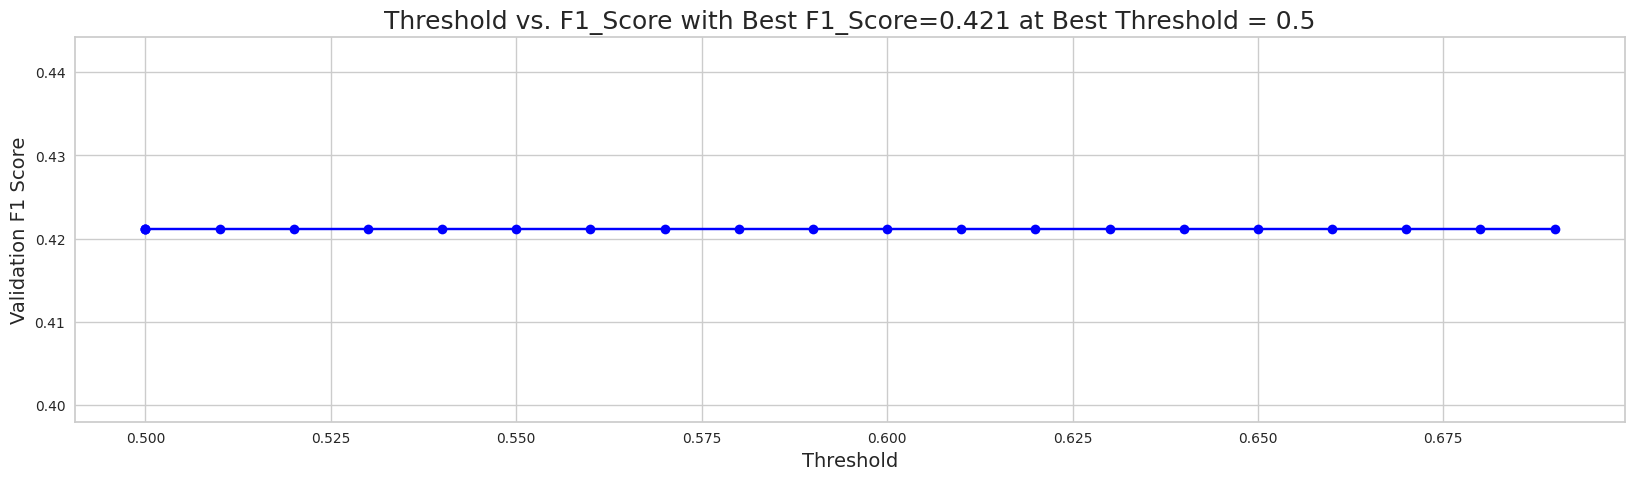

[I 2023-05-22 17:21:58,516] Trial 2 finished with value: 0.4211237500921308 and parameters: {'depth': 6, 'subsample': 0.6323876624536301}. Best is trial 0 with value: 0.4211237500921308.


When using optimal threshold = 0.50...
Q0: F1 = 0.4211237500921308
==> Overall F1 = 0.4211237500921308
s


  0%|          | 0/1 [00:00<?, ?it/s]

--------------------------------------------------
question1, with148features
--------------------------------------------------
[LightGBM] [Warning] early_stopping_round is set=75, early_stopping_rounds=75 will be ignored. Current value: early_stopping_round=75
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] early_stopping_round is set=75, early_stopping_rounds=75 will be ignored. Current value: early_stopping_round=75
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] early_stopping_round is set=75, early_stopping_rounds=75 will be ignored. Current value: early_stopping_round=75
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] early_stopping_round is set=75, early_stopping_rounds=75 will be ignored. Current value: early_stopping_round=75
[LightGBM] [Warning] lambda_l

  0%|          | 0/1 [00:01<?, ?it/s]
[W 2023-05-22 17:22:00,089] Trial 3 failed with parameters: {'depth': 5, 'subsample': 0.5617585920831265} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_1930/3631055986.py", line 58, in objective_lgbm
    model = model.fit(train_x[FEATURES], train_y['correct'],
  File "/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py", line 967, in fit
    super().fit(X, _y, sample_weight=sample_weight, init_score=init_score, eval_set=valid_sets,
  File "/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py", line 748, in fit
    self._Booster = train(
  File "/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py", line 271, in train
    booster = Booster(params=params, train_set=train_set)
  File "/opt/conda/lib/python3.10/site-packages/lightgbm/ba

[LightGBM] [Warning] early_stopping_round is set=75, early_stopping_rounds=75 will be ignored. Current value: early_stopping_round=75
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20


KeyboardInterrupt: 

In [89]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_lgbm, n_trials=1000)

# Get the best hyperparameters
best_params = study.best_params
print(best_params)

In [ ]:

import pickle
importance_dict = {}
for t in range(1, 19):
    if t<=3: 
        importance_dict[str(t)] = FEATURES1
    elif t<=13: 
        importance_dict[str(t)] = FEATURES2
    elif t<=22:
        importance_dict[str(t)] = FEATURES3

f_save = open('importance_dict.pkl', 'wb')
pickle.dump(importance_dict, f_save)
f_save.close()

